# Simulating long experiments

This notebook introduces functionality for simulating experiments over hundreds or even thousands of cycles. 

In [1]:
# %pip install pybamm -q
import pybamm
import matplotlib.pyplot as plt
import numpy as np

pybamm.set_logging_level("NOTICE")

## Simulating long experiments

In the interest of simplicity and running time, we consider a SPM with SEI effects leading to linear degradation, with parameter values chosen so that the capacity fades by 20% in just a few cycles

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

We can simulate many CCCV cycles. Here we simulate either 100 cycles or until the capacity is 80% of the initial capacity, whichever is first. The capacity is calculated by the eSOH model

In [3]:
experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
     "Discharge at 1C until 3V",
     "Rest for 1 hour")
] * 100,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2022-10-03 10:20:12.777 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/100 (27.116 ms elapsed) --------------------
2022-10-03 10:20:12.777 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 1/4: Charge at 1C until 4.2V
2022-10-03 10:20:12.853 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 2/4: Hold at 4.2V until C/50
2022-10-03 10:20:12.941 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 3/4: Discharge at 1C until 3V
2022-10-03 10:20:13.010 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 4/4: Rest for 1 hour
2022-10-03 10:20:13.172 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-10-03 10:20:13.173 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/100 (423.430 ms elapsed) --------------------
2022-10-03 10:20:13.174 - [NOTICE] callbacks.on_step_start(182): Cycle 2/100, step 1/4: Charge at 1C until 4.2V
2022-10-03 10:20:13.215 - [NOTICE] callbacks.on_step_start(182): Cycle 2/1

We can plot standard variables like the current and voltage, but it isn't very instructive on these timescales

In [4]:
sol.plot(["Current [A]", "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=146.98804549875837, step=1.4698804549875837)…

Some other variables are more interesting

In [7]:
sim.plot([
    "Negative electrode SOC", 
    "Positive electrode SOC",
    "Total lithium in particles [mol]",
    "Loss of lithium to SEI [mol]",
    "X-averaged SEI thickness [m]",
])

interactive(children=(FloatSlider(value=0.0, description='t', max=146.98804549875837, step=1.4698804549875837)…

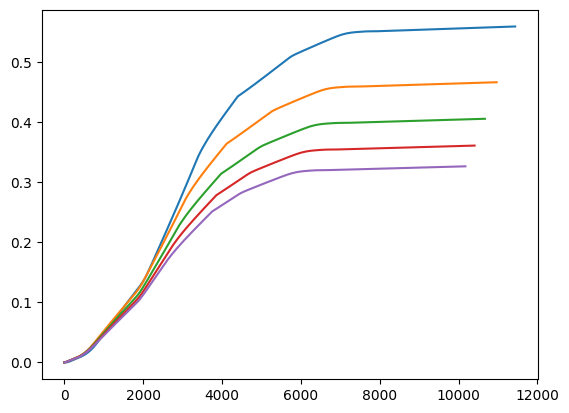

In [12]:
fig, ax = plt.subplots()
for i,cycle in enumerate(sim.solution.cycles):
    if i%10==0:
        t = cycle["Time [s]"].data
        LLI = cycle["Loss of lithium inventory [%]"].data
        ax.plot(t-t[0], LLI-LLI[0])

## Summary variables

We can also plot "summary variables", which show how the battery degrades over time by various metrics. Some of the variables also have "Change in ...", which is how much that variable changes over each cycle.

In [13]:
sorted(sol.summary_variables.keys())

['C',
 'C_n',
 'C_n * (x_100 - x_0)',
 'C_p',
 'C_p * (y_100 - y_0)',
 'Capacity [A.h]',
 'Change in local ECM resistance [Ohm]',
 'Change in loss of active material in negative electrode [%]',
 'Change in loss of active material in positive electrode [%]',
 'Change in loss of capacity to SEI [A.h]',
 'Change in loss of capacity to SEI on cracks [A.h]',
 'Change in loss of capacity to lithium plating [A.h]',
 'Change in loss of lithium inventory [%]',
 'Change in loss of lithium inventory, including electrolyte [%]',
 'Change in loss of lithium to SEI [mol]',
 'Change in loss of lithium to SEI on cracks [mol]',
 'Change in loss of lithium to lithium plating [mol]',
 'Change in negative electrode capacity [A.h]',
 'Change in positive electrode capacity [A.h]',
 'Change in throughput capacity [A.h]',
 'Change in throughput energy [W.h]',
 'Change in time [h]',
 'Change in time [s]',
 'Change in total capacity lost to side reactions [A.h]',
 'Change in total lithium [mol]',
 'Change in to

Here the only degradation mechanism is one that causes loss of lithium, so we don't see loss of active material

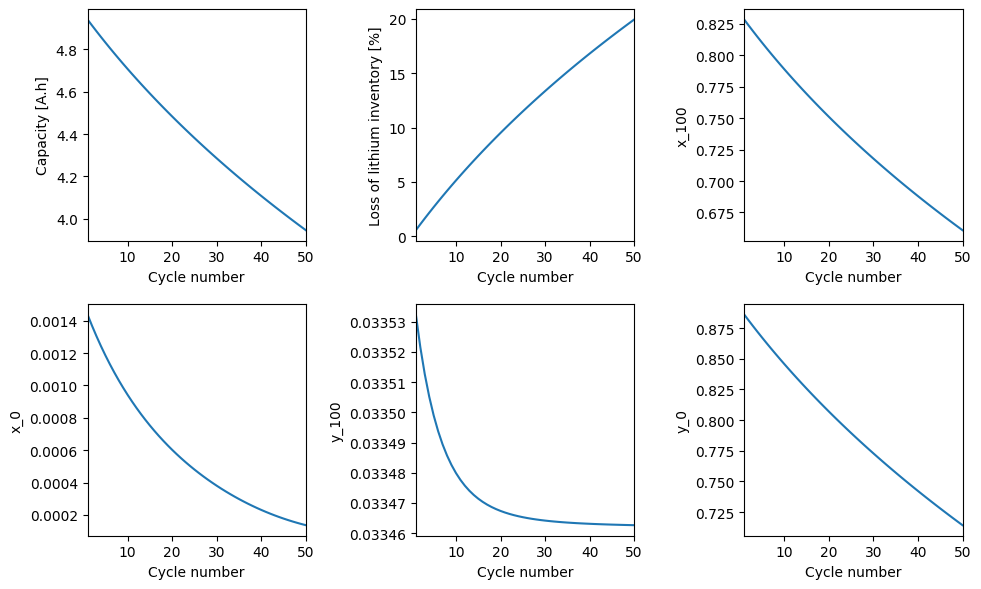

In [16]:
vars_to_plot = [
    "Capacity [A.h]",
    "Loss of lithium inventory [%]",
    "x_100",
    "x_0",
    "y_100",
    "y_0"
]
l = len(vars_to_plot)
n = int(l//np.sqrt(l))
m = int(np.ceil(l/n))

fig, axes = plt.subplots(n,m,figsize=(10,6))
for var, ax in zip(vars_to_plot,axes.flat):
    ax.plot(sol.summary_variables["Cycle number"], sol.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1,sol.summary_variables["Cycle number"][-1]])
fig.tight_layout()
# 这里的x_0,x_100,y_100,y_0是什么意思

To suggest additional summary variables, open an issue!

## Choosing which cycles to save

If the simulation contains thousands of cycles, saving each cycle in RAM might not be possible. To get around this, we can use `save_at_cycles`. If this is an integer `n`, every nth cycle is saved. If this is a list, all the cycles in the list are saved.
The first cycle is always saved.

In [17]:
# With integer
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_int = sim.solve(save_at_cycles=5)
# With list
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_list = sim.solve(save_at_cycles=[20,30,45])

2022-10-03 11:41:05.366 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/100 (27.668 ms elapsed) --------------------
2022-10-03 11:41:05.367 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 1/4: Charge at 1C until 4.2V
2022-10-03 11:41:05.443 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 2/4: Hold at 4.2V until C/50
2022-10-03 11:41:05.520 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 3/4: Discharge at 1C until 3V
2022-10-03 11:41:05.593 - [NOTICE] callbacks.on_step_start(182): Cycle 1/100, step 4/4: Rest for 1 hour
2022-10-03 11:41:05.764 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-10-03 11:41:05.765 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/100 (425.878 ms elapsed) --------------------
2022-10-03 11:41:05.765 - [NOTICE] callbacks.on_step_start(182): Cycle 2/100, step 1/4: Charge at 1C until 4.2V
2022-10-03 11:41:05.805 - [NOTICE] callbacks.on_step_start(182): Cycle 2/1

In [18]:
sol_int.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [19]:
sol_list.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

For the cycles that are saved, you can plot as usual (note off-by-1 indexing)

In [22]:
sol_list.cycles[29].plot(["Current [A]","Terminal voltage [V]"])

interactive(children=(FloatSlider(value=87.49405077004131, description='t', max=90.39145027016153, min=87.4940…

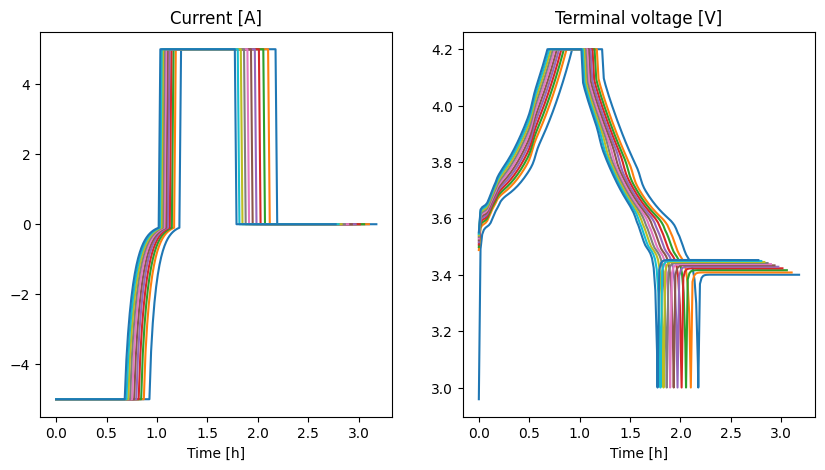

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for cycle in sol_int.cycles:
    if cycle is not None:
        t = cycle["Time [h]"].data - cycle["Time [h]"].data[0]
        ax[0].plot(t, cycle["Current [A]"].data)
        ax[0].set_xlabel("Time [h]")
        ax[0].set_title("Current [A]")
        ax[1].plot(t, cycle["Terminal voltage [V]"].data)
        ax[1].set_xlabel("Time [h]")
        ax[1].set_title("Terminal voltage [V]")

All summary variables are always available for every cycle, since these are much less memory-intensive

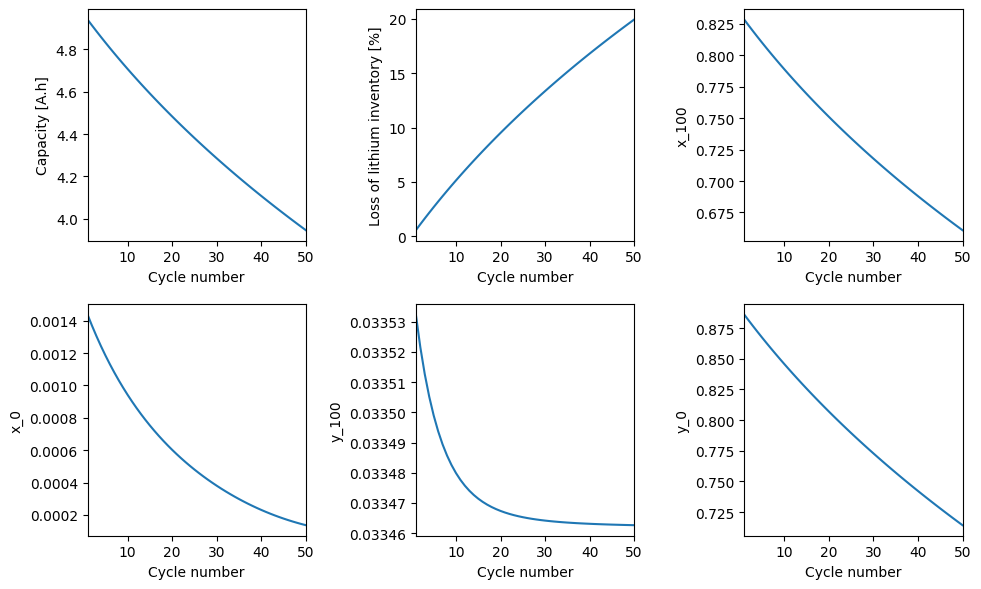

In [24]:
fig, axes = plt.subplots(n,m,figsize=(10,6))
for var, ax in zip(vars_to_plot,axes.flat):
    ax.plot(sol_list.summary_variables["Cycle number"], sol_list.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1,sol_list.summary_variables["Cycle number"][-1]])
fig.tight_layout()

## Starting solution

A simulation can be performed iteratively by using the `starting_solution` feature. For example, we first solve for 10 cycles

In [25]:
experiment = pybamm.Experiment([
    ("Charge at 1C until 4.2V", 
     "Hold at 4.2V until C/50",
     "Discharge at 1C until 3V",
     "Rest for 1 hour")
] * 10,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2022-10-03 12:02:25.971 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/10 (26.225 ms elapsed) --------------------
2022-10-03 12:02:25.972 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 1/4: Charge at 1C until 4.2V
2022-10-03 12:02:26.067 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 2/4: Hold at 4.2V until C/50
2022-10-03 12:02:26.135 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 3/4: Discharge at 1C until 3V
2022-10-03 12:02:26.205 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 4/4: Rest for 1 hour
2022-10-03 12:02:26.375 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-10-03 12:02:26.375 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/10 (430.525 ms elapsed) --------------------
2022-10-03 12:02:26.376 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, step 1/4: Charge at 1C until 4.2V
2022-10-03 12:02:26.413 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, step

If we give `sol` as the starting solution this will then solve for the next 10 cycles

In [26]:
sol2 = sim.solve(starting_solution=sol)

2022-10-03 12:04:11.691 - [NOTICE] callbacks.on_cycle_start(174): Cycle 11/20 (17.545 us elapsed) --------------------
2022-10-03 12:04:11.693 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 1/4: Charge at 1C until 4.2V
2022-10-03 12:04:11.738 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 2/4: Hold at 4.2V until C/50
2022-10-03 12:04:11.787 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 3/4: Discharge at 1C until 3V
2022-10-03 12:04:11.828 - [NOTICE] callbacks.on_step_start(182): Cycle 11/20, step 4/4: Rest for 1 hour
2022-10-03 12:04:11.904 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.683 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2022-10-03 12:04:11.905 - [NOTICE] callbacks.on_cycle_start(174): Cycle 12/20 (213.626 ms elapsed) --------------------
2022-10-03 12:04:11.906 - [NOTICE] callbacks.on_step_start(182): Cycle 12/20, step 1/4: Charge at 1C until 4.2V
2022-10-03 12:04:11.947 - [NOTICE] callbacks.on_step_start(182): Cycle 12/

We have now simulated 20 cycles

In [27]:
len(sol2.cycles)

20

In [28]:
sol2.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=61.0944517181057, step=0.610944517181057), O…